# Predicting Volatility of Cryptocurrencies

<font style = "Verdana" size = "3"><p>
Individuals and financial houses use volatility to measure the change in the price of stocks, cryptocurrencies, forex, indices and commodities (e.g. gold). In this project, we'll make use of the GARCH model to predict the volatility of BTC over time.
    <p>
        It should be noted that this project can also be used to make predictions on other cryptocurrency
</font>

# Data Preparation

## Import

**Task: Import all necessary libraries** 

In [1]:
%load_ext autoreload
%load_ext sql
%autoreload 2

In [38]:
import sqlite3
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from config import settings
from data import MyAPI, MySQLRepo
from model import Model
from arch import arch_model
from ipywidgets import interact, widgets, IntSlider

**Task: Initialize symbol (crypto coin) and market (currency)** 

In [3]:
symbol = "BTC"
market = "USD"

**Task: Get 'DIGITAL_CURRENCY_DAILY' from the MyAPI** 

In [4]:
api = MyAPI()
df = api.get_stock(symbol, market)
df.head()

,open,high,low,close,volume
date,,,,,
2023-01-05,16850.36,16878.18,16807.72,16845.29,10276.56887
2023-01-04,16675.65,16991.87,16652.66,16850.36,220362.18862
2023-01-03,16672.78,16778.40,16605.28,16675.18,159541.53733
2023-01-02,16617.17,16799.23,16548.70,16672.87,121888.57191
2023-01-01,16541.77,16628.00,16499.01,16616.75,96925.41374


In [68]:
df["close"].idxmin()

Timestamp('2020-04-15 00:00:00')

**Task: Connect to the MySQLRepo repository** 

In [5]:
connection = sqlite3.connect(settings.db_name, check_same_thread = False)
repo = MySQLRepo(connection = connection)


**Task: Insert readings (dataframe) into the database** 

In [28]:
table_name = f'{symbol}_{market}'
response = repo.insert_table(table_name = table_name, records = df, if_exists = "replace")
print(response)

{'transaction_successful': True, 'records_inserted': 1000}


**Task: Get readings (percentage change) from the database** 

In [8]:
my_model = Model(symbol = symbol, market = market, use_new_data = False, repo = repo)
y = my_model.wrangle(1000)
y.tail()

date
2022-12-31   -0.391872
2023-01-01    0.449451
2023-01-02    0.337732
2023-01-03    0.013855
2023-01-04    0.239278
Name: return, dtype: float64

## Explore

**Task: Visualize the daily return across time (i.e. daily percentage change)** 

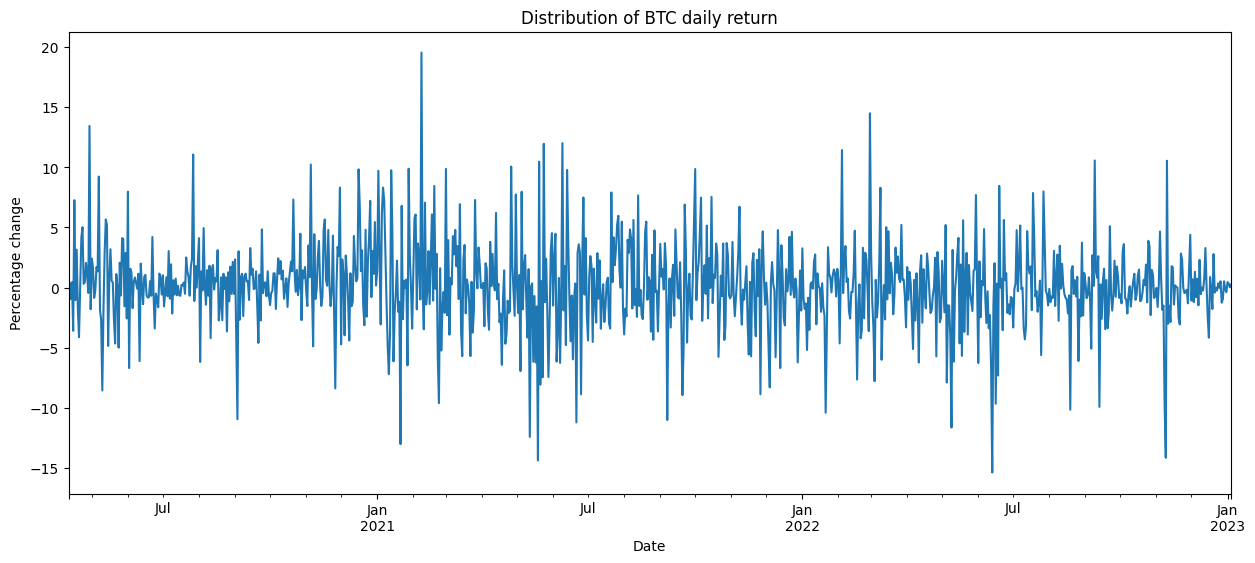

In [82]:
fig, ax = plt.subplots(figsize = [15, 6])
y.plot(ax = ax)
plt.xlabel("Date")
plt.ylabel("Percentage change")
plt.title("Distribution of BTC daily return");

**Task: Calculate the daily volatility** 

In [10]:
print("The daily volatility is: ", round(y.std(), 3))

The daily volatility is:  3.628


**Task: Calculate the annual volatility** 

In [11]:
print("The annual volatility is: ", round(y.std() * np.sqrt(365), 3))

The annual volatility is:  69.307


**Task: Visualize the 10-day rolling-volatility window** 

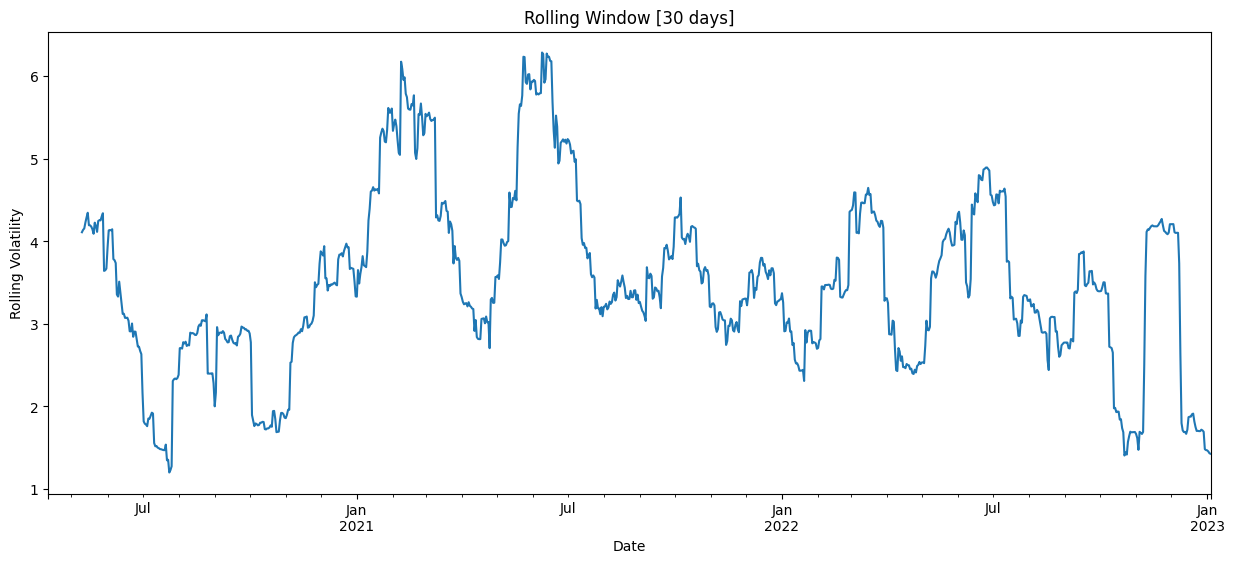

In [71]:
fig, ax = plt.subplots(figsize = [15, 6])
y.rolling(30).std().plot(ax = ax)
plt.xlabel("Date")
plt.ylabel("Rolling Volatility")
plt.title("Rolling Window [30 days]");

In [74]:
y.rolling(30).std().nlargest(10)

date
2021-06-09    6.283886
2021-06-13    6.271498
2021-06-10    6.264932
2021-05-24    6.232841
2021-06-15    6.232604
2021-06-14    6.231999
2021-05-25    6.228947
2021-06-16    6.182890
2021-06-17    6.178296
2021-02-08    6.172635
Name: return, dtype: float64

**Task: Visualize the daily trend of the symbol** 

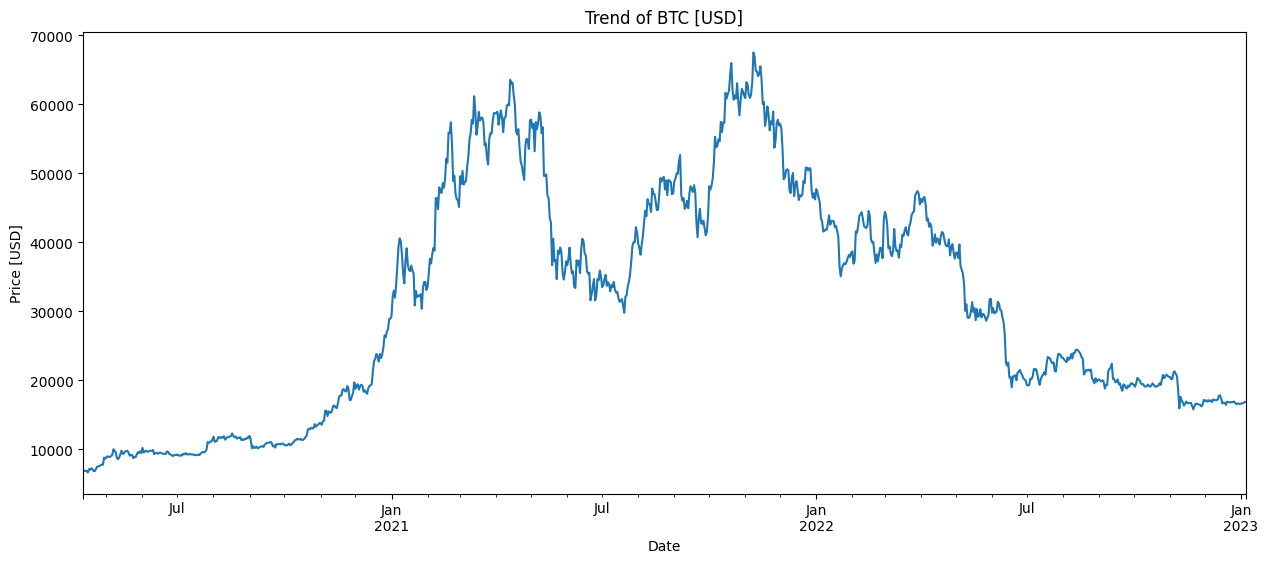

In [78]:
fig, ax = plt.subplots(figsize = [15, 6])
df["close"].plot(ax = ax);
plt.xlabel("Date")
plt.ylabel(f"Price [{market}]")
plt.title(f"Trend of {symbol} [{market}]");

**Task: Visualize the conditional volatility (Histogram)**

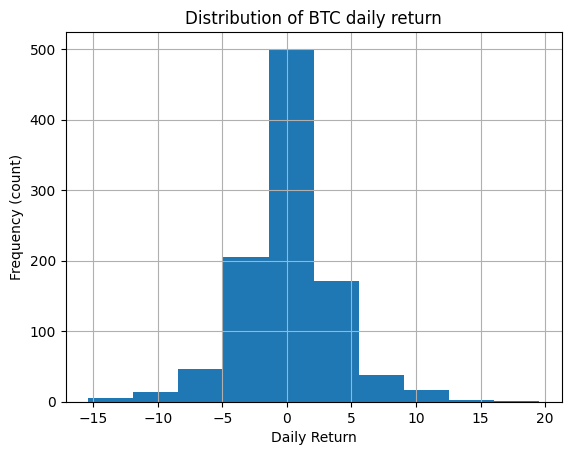

In [80]:
y.hist()
plt.title("Distribution of BTC daily return")
plt.xlabel("Daily Return")
plt.ylabel("Frequency (count)");

**Task: Visualize the squared returns** 

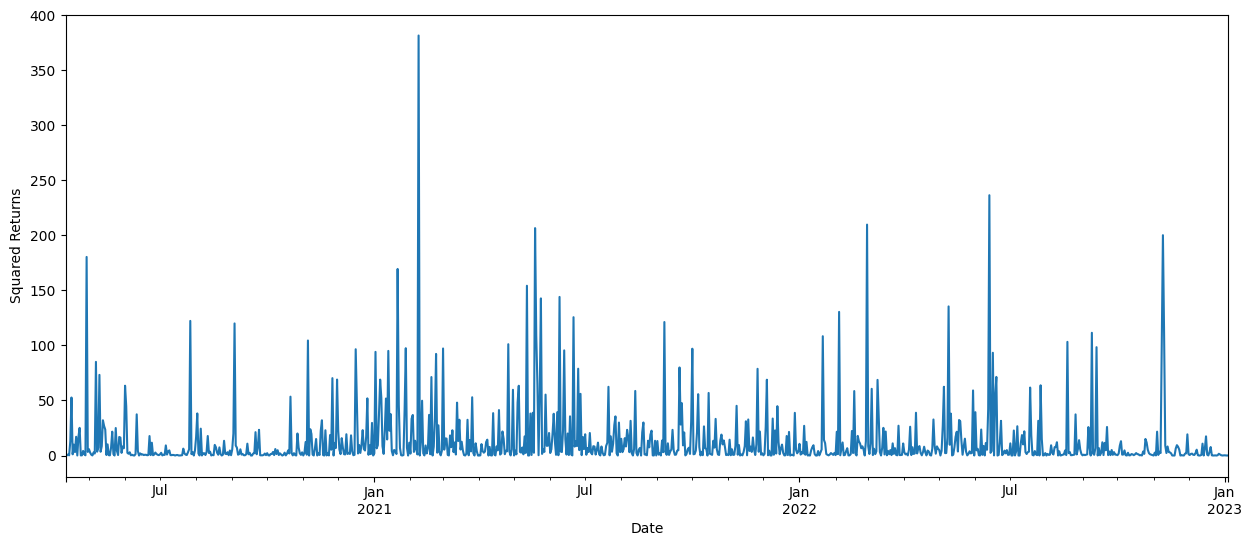

In [14]:
fig, ax = plt.subplots(figsize = [15, 6])
(y**2).plot(ax = ax)
plt.xlabel("Date")
plt.ylabel("Squared Returns");

**Task: Visualize the autocorrelation** 

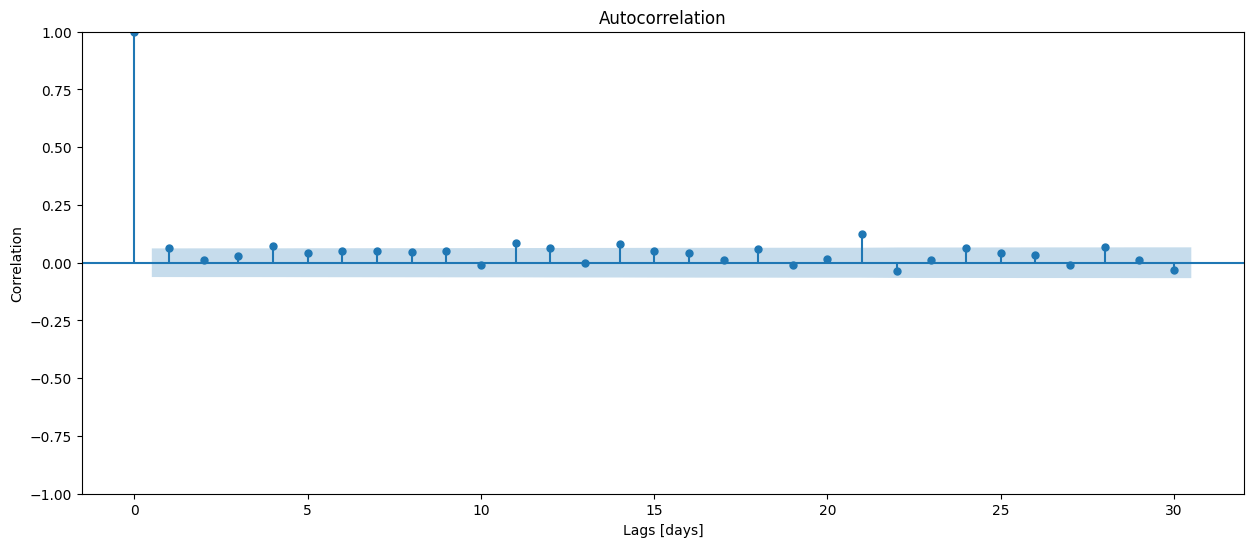

In [15]:
fig, ax = plt.subplots(figsize = [15, 6])
plot_acf((y**2), ax = ax)
plt.xlabel("Lags [days]")
plt.ylabel("Correlation");

**Task: Visualize the partial autocorrelation** 

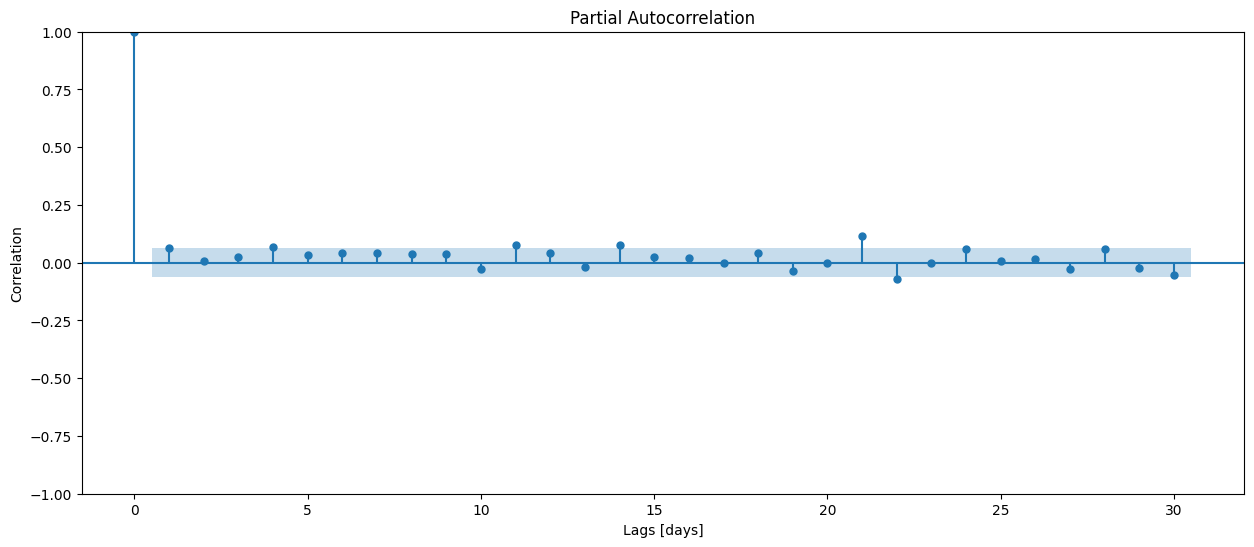

In [16]:
fig, ax = plt.subplots(figsize = [15, 6])
plot_pacf((y**2), ax = ax, method = 'ywm')
plt.xlabel("Lags [days]")
plt.ylabel("Correlation");

## Split

**Task: Create a train-test-split (cut-off)**

In [17]:
cut_off = int(len(y) * 0.70)
y_train, y_test = y.iloc[:cut_off], y.iloc[cut_off:]

# Model Building

## Iterate

**Task: Train an arch model and print the model summary**

In [75]:
model = arch_model(y_train, p = 1, q = 1,rescale=False).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1904.86
Distribution:                  Normal   AIC:                           3817.72
Method:            Maximum Likelihood   BIC:                           3835.92
                                        No. Observations:                  699
Date:                Thu, Jan 05 2023   Df Residuals:                      698
Time:                        15:11:38   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3293      0.135      2.439  1.472e-02 [6.471e-02,  0.594]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.2858      0.175      1.637      0.102  [-5.630e-02,  0.628]
alpha[1]       0.0325  1.131e-02      2.872  4.074e-03 [1.032e-02,5.467e-02]
beta[1]        0.9480  1.488e-02     63.721      0.000     [  0.919,  0.977]
============================================================================

Covariance estimator: robust
"""

**Comment: The best metrics (level of significance) are p = 1 and q = 1**

## Evaluate

**Task: Visualize the model residual**

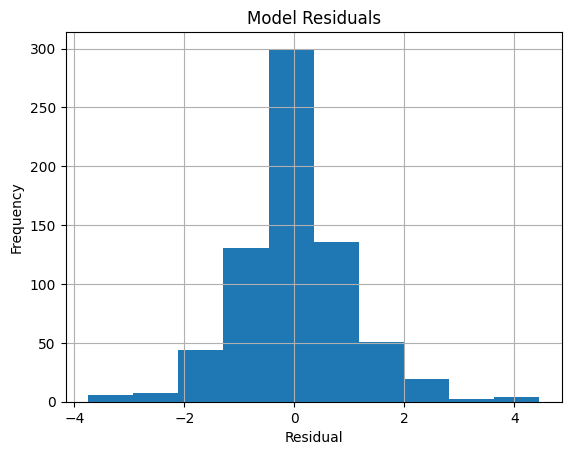

In [84]:
model.std_resid.hist()
plt.title("Model Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency");

**Task: Visualize the model autocorrelation** 

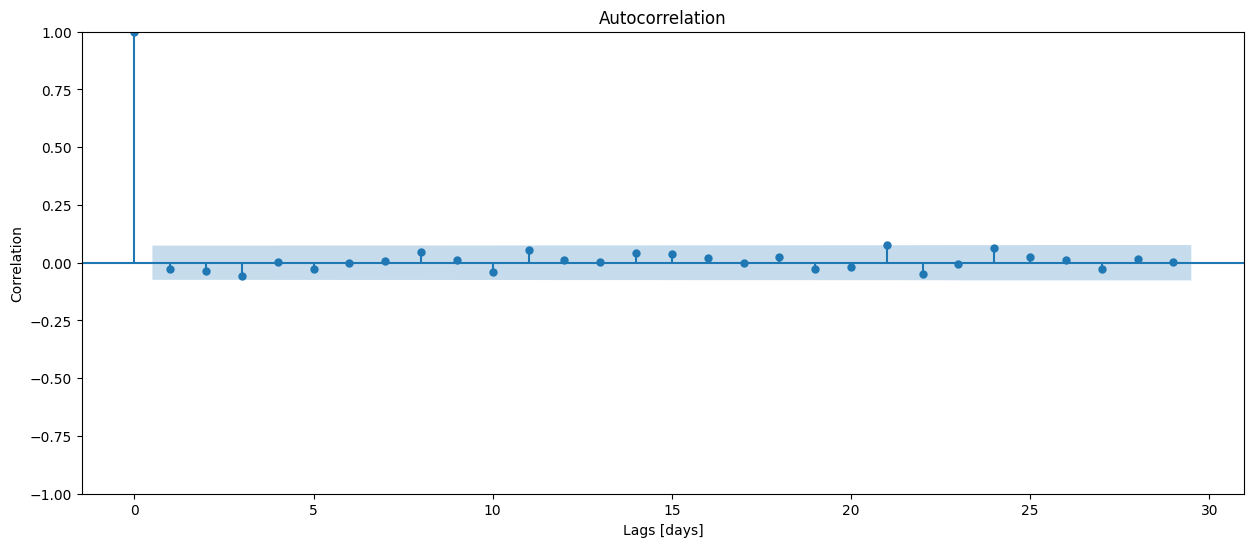

In [23]:
fig, ax = plt.subplots(figsize = [15, 6])
plot_acf(model.std_resid **2, ax = ax);
plt.xlabel("Lags [days]")
plt.ylabel("Correlation");

**Task: Perform Walk-Forward Validation to generate Test Predictions** 

In [24]:
predictions = []
test_size = len(y_test)
for i in range(test_size):
    test_data = y.iloc[:-(test_size-i)]
    model = arch_model(test_data, p = 1, q = 1,rescale=False).fit(disp=0)
    next_pred = (model.forecast(horizon = 1, reindex = False).variance.iloc[0,0])**0.5
    predictions.append(next_pred)

**Task: Create a series of test predictions** 

In [25]:
y_pred = pd.Series(predictions, index = y.tail(test_size).index)
y_pred.head()

date
2022-03-11    4.323363
2022-03-12    4.253152
2022-03-13    4.169073
2022-03-14    4.126524
2022-03-15    4.141623
dtype: float64

# Communicate of Findings and Results

**Task: Visualize the predicted volatility** 

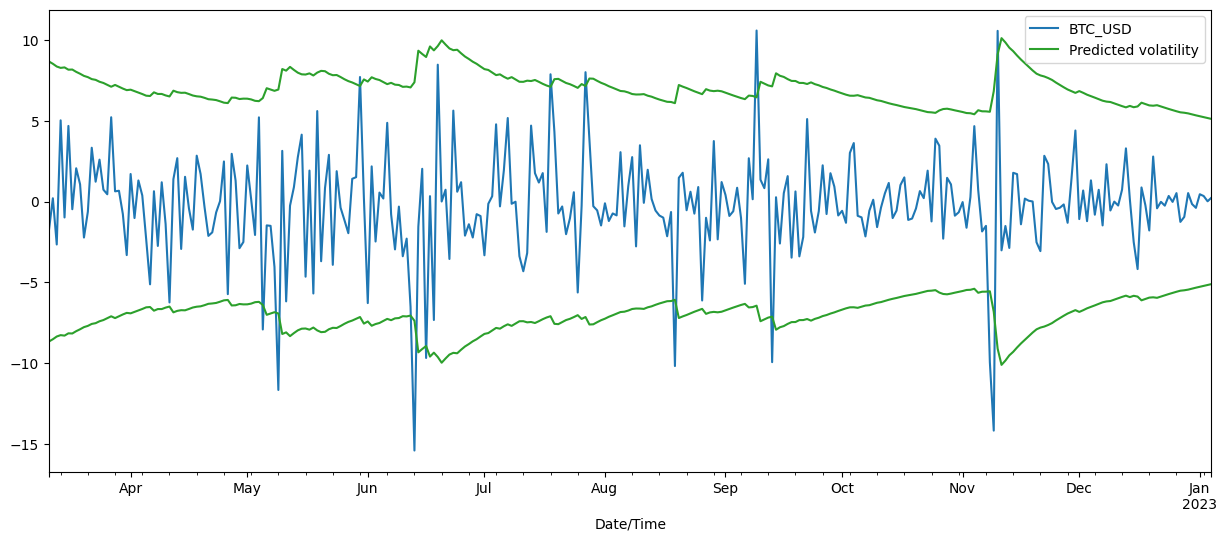

In [26]:
fig, ax = plt.subplots(figsize = [15, 6])
y.tail(test_size).plot(ax = ax, label = table_name)
(2 * y_pred).plot(ax = ax, color = "C2", label = "Predicted volatility")
(-2 * y_pred).rename().plot(ax = ax, color = "C2")
plt.xlabel("Date/Time")
plt.legend();

**Task: Create a function to generate prediction**

In [33]:
def make_predictions(n_days = 5):
    ftr_pred = model.forecast(horizon = n_days, reindex = False).variance ** 0.5
    
    start = ftr_pred.index[0] + pd.DateOffset(days = 1)
    p_date = pd.bdate_range(start = start, periods = ftr_pred.shape[1])
    
#     p_date = [d.isoformat() for d in p_date]
    data = ftr_pred.values.flatten()
    my_dict = {"Date" : p_date, "Predicted_Volatility": data}
    
    pred_vol = pd.DataFrame.from_dict(my_dict)
    
    high_vals = []
    low_vals = []
    value = df["close"].iloc[0]
    for i in range(n_days):
        high_vals.append(value + pred_vol["Predicted_Volatility"].iloc[i])
        low_vals.append(value - pred_vol["Predicted_Volatility"].iloc[i])
    pred_vol["Max_Value"] = high_vals
    pred_vol["Min_Value"] = low_vals
    pred_vol.index = pred_vol["Date"]
    
    pred_vol.drop(columns = ["Date"], inplace = True)
    return pred_vol
    
    
prediction_df = make_predictions()
prediction_df

,Predicted_Volatility,Max_Value,Min_Value
Date,,,
2023-01-04,2.550415,16847.840415,16842.739585
2023-01-05,2.599061,16847.889061,16842.690939
2023-01-06,2.645046,16847.935046,16842.644954
2023-01-09,2.688570,16847.978570,16842.601430
2023-01-10,2.729814,16848.019814,16842.560186


In [39]:
interact(
    make_predictions,
    n_days = IntSlider(
        value = 5,
        steps = 1,
        min = 1,
        max = 30
    )
);

interactive(children=(IntSlider(value=5, description='n_days', max=30, min=1), Output()), _dom_classes=('widge…

<font style = "Verdana">
    At the time of this report,
    <ul>
        <li>The highest percentage change of BTC (USD) since 11th of April, 2020 is 19.54%, while the least is -15.38%</li>
        <li>The most frequent conditional volatility is between 3.5 and 4.0</li>
        <li>The average daily volatility is approximately 3.628
        <li>The average annual volatility is approximately 69.307
        <li> The highest value recorded by BTC is USD 67525.83 in November 2021
        <li> The least value recorded by BTC is USD 6621.24 in April 2020
    </ul>
</font>